<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#生成数据集" data-toc-modified-id="生成数据集-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>生成数据集</a></span></li><li><span><a href="#构建神经网络" data-toc-modified-id="构建神经网络-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>构建神经网络</a></span></li><li><span><a href="#训练神经网络,并查看精度" data-toc-modified-id="训练神经网络,并查看精度-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>训练神经网络,并查看精度</a></span></li><li><span><a href="#结果可视化" data-toc-modified-id="结果可视化-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>结果可视化</a></span></li><li><span><a href="#取d不同时算法结果" data-toc-modified-id="取d不同时算法结果-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>取d不同时算法结果</a></span><ul class="toc-item"><li><span><a href="#d=4" data-toc-modified-id="d=4-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>d=4</a></span></li><li><span><a href="#d=-2" data-toc-modified-id="d=-2-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>d=-2</a></span></li><li><span><a href="#d=-5" data-toc-modified-id="d=-5-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>d=-5</a></span></li></ul></li></ul></div>

# 生成数据集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

class make_data:#创建一个类，用来生成数据集
    def __init__(self,n, r=10, w=6, d=1):#构造函数，n为样本点的数量，r为半径，d为上下数据集之间的间隔
        r1 = r-w/2
        r2 = r+w/2
        #上半圆
        theta1 =  np.random.uniform(0, np.pi ,n)
        X_Col1 = np.random.uniform( r1*np.cos(theta1),r2*np.cos(theta1),n)[:, np.newaxis]
        X_Row1 = np.random.uniform(r1*np.sin(theta1),r2*np.sin(theta1),n)[:, np.newaxis]
        Y_label1 = np.ones(n) #类别标签为1
        #下半圆
        theta2 = np.random.uniform(-np.pi, 0 ,n)
        X_Col2 = (np.random.uniform( r1*np.cos(theta2),r2*np.cos(theta2),n) + r)[:, np.newaxis]
        X_Row2 = (np.random.uniform(r1 * np.sin(theta2), r2 * np.sin(theta2), n) -d)[:,np.newaxis]
        Y_label2 = np.zeros(n) #类别标签为0
        #合并
        X_Col = np.vstack((X_Col1, X_Col2))
        X_Row = np.vstack((X_Row1, X_Row2))
        
        self.X= np.hstack((X_Col, X_Row))#双月亮的特征
        self.Y=np.hstack((Y_label1,Y_label2))#双月亮的标签
        
    def plot(self):#对生成的数据进行绘图
        fig = plt.figure()
        plt.title('moon_data')
        plt.scatter(self.X[0:499,0], self.X[0:499,1], marker='x',color='g')
        plt.scatter(self.X[500:,0], self.X[500:,1], marker='+',color='r')
        plt.show()

    def change_tensor(self):#将数据转化为torch格式
        X = torch.from_numpy(self.X).type(torch.FloatTensor)
        y = torch.from_numpy(self.Y).type(torch.LongTensor)
        return X,y

# 构建神经网络

可以看到我们生成了两类数据，分别用 0 和 1 来表示。我们接下来将要在这个样本数据上构造一个分类器，采用的是一个很简单的全连接网络，网络结构如下：

In [2]:
from IPython.display import Image
Image(url='https://www.pytorchtutorial.com/wp-content/uploads/2019/02/1tw8R_bbcTNUDcytbah5Tow-768x423.png')

这个网络包含一个输入层，一个中间层，一个输出层。中间层包含 3 个神经元，使用的激活函数是 tanh。当然，中间层的神经元越多，分类效果一般越好，但这个 3 层的网络对于我们的样本数据已经足够用了。我们来算一下参数数量：上图中一共有 6 6 = 12 条线，就是 12 个权重，加上 3 2 = 5 个 bias，一共 17 个参数需要训练。

In [3]:
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):#定义一个网络类
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2,3)
        self.fc2 = nn.Linear(3,2)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x
             
    def predict(self,x):
        pred = F.softmax(self.forward(x))
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [4]:
model = Net()
criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam梯度优化器

# 训练神经网络,并查看精度

In [5]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
def train(X,y):
    epochs = 1000
    losses = []
    for i in range(epochs):
        y_pred = model.forward(X)
        loss = criterion(y_pred,y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('第{}次训练精度为:{}'.format(i,accuracy_score(model.predict(X),y)))

# 结果可视化

In [6]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.predict(x)
    return ans.numpy()

In [7]:
def plot_decision_boundary(pred_func,X,y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max()+.5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() +  .5
    h = 0.01
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

# 取d不同时算法结果

## d=4

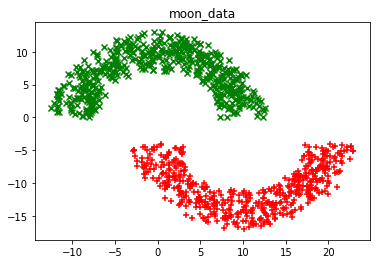

In [9]:
d_1=make_data(n=500,d=4)
d_1.plot()
X,y=d_1.change_tensor()

In [10]:
train(X,y)

第0次训练精度为:0.616
第1次训练精度为:0.652
第2次训练精度为:0.686
第3次训练精度为:0.715
第4次训练精度为:0.74
第5次训练精度为:0.78
第6次训练精度为:0.819
第7次训练精度为:0.849
第8次训练精度为:0.886
第9次训练精度为:0.916
第10次训练精度为:0.938
第11次训练精度为:0.963
第12次训练精度为:0.966
第13次训练精度为:0.975
第14次训练精度为:0.981
第15次训练精度为:0.986
第16次训练精度为:0.986
第17次训练精度为:0.987
第18次训练精度为:0.991
第19次训练精度为:0.992
第20次训练精度为:0.993
第21次训练精度为:0.993
第22次训练精度为:0.993
第23次训练精度为:0.993
第24次训练精度为:0.995
第25次训练精度为:0.995
第26次训练精度为:0.996
第27次训练精度为:0.996
第28次训练精度为:0.996
第29次训练精度为:0.996
第30次训练精度为:0.996
第31次训练精度为:0.996
第32次训练精度为:0.998
第33次训练精度为:0.999
第34次训练精度为:0.999
第35次训练精度为:1.0
第36次训练精度为:1.0
第37次训练精度为:1.0
第38次训练精度为:1.0
第39次训练精度为:1.0
第40次训练精度为:1.0
第41次训练精度为:1.0
第42次训练精度为:1.0
第43次训练精度为:1.0
第44次训练精度为:1.0
第45次训练精度为:1.0
第46次训练精度为:1.0
第47次训练精度为:1.0
第48次训练精度为:1.0
第49次训练精度为:1.0
第50次训练精度为:1.0
第51次训练精度为:1.0
第52次训练精度为:1.0
第53次训练精度为:1.0
第54次训练精度为:1.0
第55次训练精度为:1.0
第56次训练精度为:1.0
第57次训练精度为:1.0
第58次训练精度为:1.0
第59次训练精度为:1.0
第60次训练精度为:1.0
第61次训练精度为:1.0
第62次训练精度为:1.0
第63次训练精度为:1.0
第64次训练精度为:1.0
第65次训练精度为:1.0
第66次训练精度为:1.0
第67次

第549次训练精度为:1.0
第550次训练精度为:1.0
第551次训练精度为:1.0
第552次训练精度为:1.0
第553次训练精度为:1.0
第554次训练精度为:1.0
第555次训练精度为:1.0
第556次训练精度为:1.0
第557次训练精度为:1.0
第558次训练精度为:1.0
第559次训练精度为:1.0
第560次训练精度为:1.0
第561次训练精度为:1.0
第562次训练精度为:1.0
第563次训练精度为:1.0
第564次训练精度为:1.0
第565次训练精度为:1.0
第566次训练精度为:1.0
第567次训练精度为:1.0
第568次训练精度为:1.0
第569次训练精度为:1.0
第570次训练精度为:1.0
第571次训练精度为:1.0
第572次训练精度为:1.0
第573次训练精度为:1.0
第574次训练精度为:1.0
第575次训练精度为:1.0
第576次训练精度为:1.0
第577次训练精度为:1.0
第578次训练精度为:1.0
第579次训练精度为:1.0
第580次训练精度为:1.0
第581次训练精度为:1.0
第582次训练精度为:1.0
第583次训练精度为:1.0
第584次训练精度为:1.0
第585次训练精度为:1.0
第586次训练精度为:1.0
第587次训练精度为:1.0
第588次训练精度为:1.0
第589次训练精度为:1.0
第590次训练精度为:1.0
第591次训练精度为:1.0
第592次训练精度为:1.0
第593次训练精度为:1.0
第594次训练精度为:1.0
第595次训练精度为:1.0
第596次训练精度为:1.0
第597次训练精度为:1.0
第598次训练精度为:1.0
第599次训练精度为:1.0
第600次训练精度为:1.0
第601次训练精度为:1.0
第602次训练精度为:1.0
第603次训练精度为:1.0
第604次训练精度为:1.0
第605次训练精度为:1.0
第606次训练精度为:1.0
第607次训练精度为:1.0
第608次训练精度为:1.0
第609次训练精度为:1.0
第610次训练精度为:1.0
第611次训练精度为:1.0
第612次训练精度为:1.0
第613次训练精度为:1.0
第614次训练精度为:1.0
第615次训练精度为

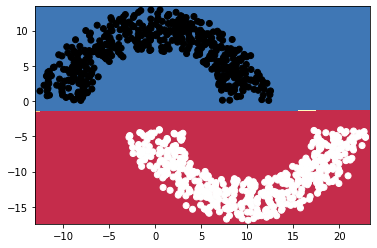

In [11]:
plot_decision_boundary(lambda x : predict(x) ,X.numpy(), y.numpy())

## d=-2

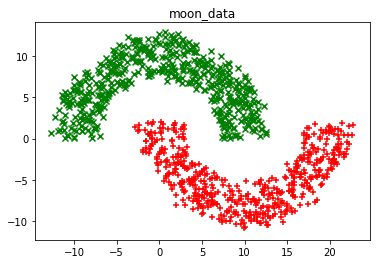

In [13]:
d_1=make_data(n=500,d=-2)
d_1.plot()
X,y=d_1.change_tensor()

In [14]:
train(X,y)

第0次训练精度为:0.908
第1次训练精度为:0.921
第2次训练精度为:0.944
第3次训练精度为:0.944
第4次训练精度为:0.935
第5次训练精度为:0.931
第6次训练精度为:0.927
第7次训练精度为:0.921
第8次训练精度为:0.916
第9次训练精度为:0.917
第10次训练精度为:0.919
第11次训练精度为:0.923
第12次训练精度为:0.927
第13次训练精度为:0.93
第14次训练精度为:0.936
第15次训练精度为:0.939
第16次训练精度为:0.94
第17次训练精度为:0.942
第18次训练精度为:0.944
第19次训练精度为:0.944
第20次训练精度为:0.946
第21次训练精度为:0.946
第22次训练精度为:0.948
第23次训练精度为:0.953
第24次训练精度为:0.954
第25次训练精度为:0.955
第26次训练精度为:0.955
第27次训练精度为:0.954
第28次训练精度为:0.951
第29次训练精度为:0.95
第30次训练精度为:0.949
第31次训练精度为:0.95
第32次训练精度为:0.95
第33次训练精度为:0.949
第34次训练精度为:0.948
第35次训练精度为:0.946
第36次训练精度为:0.945
第37次训练精度为:0.946
第38次训练精度为:0.945
第39次训练精度为:0.947
第40次训练精度为:0.948
第41次训练精度为:0.949
第42次训练精度为:0.948
第43次训练精度为:0.95
第44次训练精度为:0.951
第45次训练精度为:0.95
第46次训练精度为:0.95
第47次训练精度为:0.95
第48次训练精度为:0.95
第49次训练精度为:0.95
第50次训练精度为:0.951
第51次训练精度为:0.951
第52次训练精度为:0.951
第53次训练精度为:0.952
第54次训练精度为:0.953
第55次训练精度为:0.952
第56次训练精度为:0.951
第57次训练精度为:0.952
第58次训练精度为:0.951
第59次训练精度为:0.951
第60次训练精度为:0.951
第61次训练精度为:0.949
第62次训练精度为:0.951
第63次训练精度为:0.9

第493次训练精度为:0.955
第494次训练精度为:0.955
第495次训练精度为:0.955
第496次训练精度为:0.955
第497次训练精度为:0.955
第498次训练精度为:0.955
第499次训练精度为:0.955
第500次训练精度为:0.955
第501次训练精度为:0.955
第502次训练精度为:0.955
第503次训练精度为:0.955
第504次训练精度为:0.955
第505次训练精度为:0.955
第506次训练精度为:0.955
第507次训练精度为:0.955
第508次训练精度为:0.955
第509次训练精度为:0.955
第510次训练精度为:0.955
第511次训练精度为:0.955
第512次训练精度为:0.955
第513次训练精度为:0.955
第514次训练精度为:0.955
第515次训练精度为:0.955
第516次训练精度为:0.955
第517次训练精度为:0.955
第518次训练精度为:0.955
第519次训练精度为:0.955
第520次训练精度为:0.955
第521次训练精度为:0.955
第522次训练精度为:0.955
第523次训练精度为:0.955
第524次训练精度为:0.955
第525次训练精度为:0.955
第526次训练精度为:0.955
第527次训练精度为:0.955
第528次训练精度为:0.955
第529次训练精度为:0.956
第530次训练精度为:0.956
第531次训练精度为:0.956
第532次训练精度为:0.956
第533次训练精度为:0.956
第534次训练精度为:0.956
第535次训练精度为:0.956
第536次训练精度为:0.956
第537次训练精度为:0.956
第538次训练精度为:0.956
第539次训练精度为:0.956
第540次训练精度为:0.956
第541次训练精度为:0.956
第542次训练精度为:0.956
第543次训练精度为:0.956
第544次训练精度为:0.956
第545次训练精度为:0.956
第546次训练精度为:0.956
第547次训练精度为:0.956
第548次训练精度为:0.956
第549次训练精度为:0.956
第550次训练精度为:0.956
第551次训练精度为:0.9

第987次训练精度为:0.96
第988次训练精度为:0.96
第989次训练精度为:0.96
第990次训练精度为:0.96
第991次训练精度为:0.96
第992次训练精度为:0.96
第993次训练精度为:0.96
第994次训练精度为:0.96
第995次训练精度为:0.961
第996次训练精度为:0.961
第997次训练精度为:0.961
第998次训练精度为:0.961
第999次训练精度为:0.961


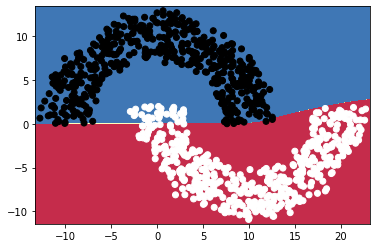

In [15]:
plot_decision_boundary(lambda x : predict(x) ,X.numpy(), y.numpy())

## d=-5

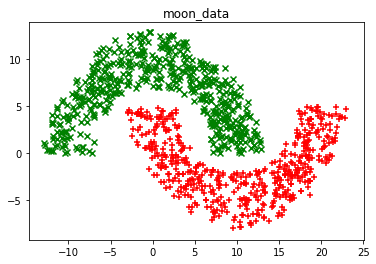

In [17]:
d_1=make_data(n=500,d=-5)
d_1.plot()
X,y=d_1.change_tensor()

In [18]:
train(X,y)

第0次训练精度为:0.866
第1次训练精度为:0.88
第2次训练精度为:0.88
第3次训练精度为:0.869
第4次训练精度为:0.867
第5次训练精度为:0.855
第6次训练精度为:0.84
第7次训练精度为:0.833
第8次训练精度为:0.823
第9次训练精度为:0.82
第10次训练精度为:0.807
第11次训练精度为:0.809
第12次训练精度为:0.888
第13次训练精度为:0.904
第14次训练精度为:0.903
第15次训练精度为:0.901
第16次训练精度为:0.896
第17次训练精度为:0.896
第18次训练精度为:0.901
第19次训练精度为:0.904
第20次训练精度为:0.909
第21次训练精度为:0.912
第22次训练精度为:0.911
第23次训练精度为:0.908
第24次训练精度为:0.907
第25次训练精度为:0.905
第26次训练精度为:0.904
第27次训练精度为:0.904
第28次训练精度为:0.904
第29次训练精度为:0.905
第30次训练精度为:0.907
第31次训练精度为:0.908
第32次训练精度为:0.91
第33次训练精度为:0.912
第34次训练精度为:0.913
第35次训练精度为:0.913
第36次训练精度为:0.913
第37次训练精度为:0.914
第38次训练精度为:0.914
第39次训练精度为:0.914
第40次训练精度为:0.913
第41次训练精度为:0.913
第42次训练精度为:0.913
第43次训练精度为:0.911
第44次训练精度为:0.91
第45次训练精度为:0.91
第46次训练精度为:0.909
第47次训练精度为:0.909
第48次训练精度为:0.909
第49次训练精度为:0.909
第50次训练精度为:0.909
第51次训练精度为:0.909
第52次训练精度为:0.909
第53次训练精度为:0.91
第54次训练精度为:0.91
第55次训练精度为:0.911
第56次训练精度为:0.912
第57次训练精度为:0.913
第58次训练精度为:0.913
第59次训练精度为:0.913
第60次训练精度为:0.913
第61次训练精度为:0.913
第62次训练精度为:0.912
第63次训练精度为:0

第493次训练精度为:0.914
第494次训练精度为:0.914
第495次训练精度为:0.914
第496次训练精度为:0.914
第497次训练精度为:0.914
第498次训练精度为:0.914
第499次训练精度为:0.914
第500次训练精度为:0.914
第501次训练精度为:0.914
第502次训练精度为:0.914
第503次训练精度为:0.914
第504次训练精度为:0.914
第505次训练精度为:0.914
第506次训练精度为:0.914
第507次训练精度为:0.914
第508次训练精度为:0.914
第509次训练精度为:0.914
第510次训练精度为:0.914
第511次训练精度为:0.914
第512次训练精度为:0.914
第513次训练精度为:0.914
第514次训练精度为:0.914
第515次训练精度为:0.914
第516次训练精度为:0.914
第517次训练精度为:0.914
第518次训练精度为:0.914
第519次训练精度为:0.914
第520次训练精度为:0.914
第521次训练精度为:0.914
第522次训练精度为:0.914
第523次训练精度为:0.914
第524次训练精度为:0.914
第525次训练精度为:0.914
第526次训练精度为:0.914
第527次训练精度为:0.914
第528次训练精度为:0.914
第529次训练精度为:0.914
第530次训练精度为:0.914
第531次训练精度为:0.914
第532次训练精度为:0.914
第533次训练精度为:0.914
第534次训练精度为:0.914
第535次训练精度为:0.914
第536次训练精度为:0.914
第537次训练精度为:0.914
第538次训练精度为:0.914
第539次训练精度为:0.914
第540次训练精度为:0.914
第541次训练精度为:0.914
第542次训练精度为:0.914
第543次训练精度为:0.914
第544次训练精度为:0.914
第545次训练精度为:0.914
第546次训练精度为:0.914
第547次训练精度为:0.914
第548次训练精度为:0.914
第549次训练精度为:0.914
第550次训练精度为:0.914
第551次训练精度为:0.9

第979次训练精度为:0.914
第980次训练精度为:0.914
第981次训练精度为:0.914
第982次训练精度为:0.914
第983次训练精度为:0.914
第984次训练精度为:0.914
第985次训练精度为:0.914
第986次训练精度为:0.914
第987次训练精度为:0.914
第988次训练精度为:0.914
第989次训练精度为:0.914
第990次训练精度为:0.914
第991次训练精度为:0.914
第992次训练精度为:0.914
第993次训练精度为:0.914
第994次训练精度为:0.914
第995次训练精度为:0.914
第996次训练精度为:0.914
第997次训练精度为:0.914
第998次训练精度为:0.914
第999次训练精度为:0.914


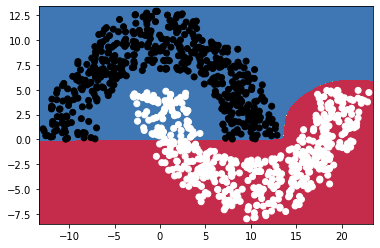

In [19]:
plot_decision_boundary(lambda x : predict(x) ,X.numpy(), y.numpy())